In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# --- シミュレーションパラメータ ---
dt = 0.1  # 時間刻み
T = 20.0  # シミュレーション時間
N = int(T / dt)  # ステップ数
np.random.seed(0)  # 再現性のため

In [3]:
# --- 真のパラメータと初期値 ---
m_true = 2.0  # 真の質量
x0_true = np.array([0.0, 0.0])  # 初期位置と速度

In [4]:
# --- 加える力（正弦波） ---
def force(t):
    return 0

In [5]:
f_input = np.zeros(N)
f_true = np.zeros(N)
x_true = np.zeros((N, 2))  # 位置と速度
x_true[0] = x0_true
z_obs = np.zeros(N)  # 観測値（位置）

In [6]:
for k in range(1, N):
    t = k * dt
    input = force(t)
    f_input[k] = input
    F = input + np.random.normal(0, 0.5)
    f_true[k] = F
    a = F / m_true
    x_true[k, 0] = x_true[k - 1, 0] + dt * x_true[k - 1, 1]
    x_true[k, 1] = x_true[k - 1, 1] + dt * a
    z_obs[k] = x_true[k, 0] + np.random.normal(0, 0.05)  # 位置観測（ノイズ付き）

In [7]:
# --- EKF 用の初期値 ---
x_est = np.zeros((N, 3))  # 推定値 [位置, 速度, 質量]
x_est[0] = [0.0, 0.0, 1.0]  # 質量の初期推定値
P_m = np.zeros(N)
P = np.diag([0.0, 0.0, 1.0])  # 初期共分散
P_m[0] = P[2,2]
Q = np.diag([0.001, 0.001, 0.0001])  # 遷移ノイズ
R = 0.05**2  # 観測ノイズ

In [8]:
# --- EKF 実装 ---
for k in range(1, N):
    # 予測ステップ
    x, v, m = x_est[k - 1]
    F = force(k * dt)
    a = F / m
    x_pred = x + dt * v
    v_pred = v + dt * a
    m_pred = m
    x_est[k] = [x_pred, v_pred, m_pred]

    # ヤコビ行列 F_k
    Fk = np.array(
        [[1,    dt,     0],
         [0,    1,      -dt * F / (m**2)],
         [0,    0,      1]]
    )

    # 予測共分散
    P = Fk @ P @ Fk.T + Q

    # 観測更新
    H = np.array([[1, 0, 0]])  # 観測行列（位置のみ）
    y = z_obs[k] - H @ x_est[k]  # 残差
    S = H @ P @ H.T + R
    K = P @ H.T / S  # カルマンゲイン
    x_est[k] += K.flatten() * y
    P = (np.eye(3) - K @ H) @ P
    P_m[k] = P[2,2]

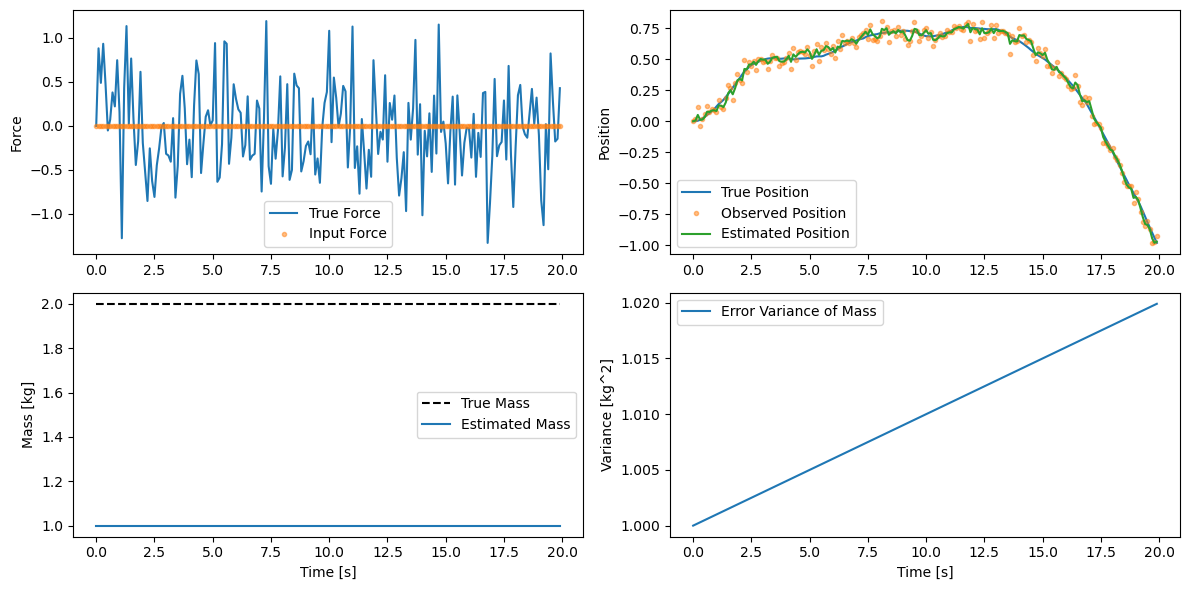

In [9]:
# --- 結果プロット ---
t_vals = np.arange(N) * dt
mass_est = x_est[:, 2]

plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(t_vals, f_true, label="True Force")
plt.plot(t_vals, f_input, ".", label="Input Force", alpha=0.5)
plt.ylabel("Force")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(t_vals, x_true[:, 0], label="True Position")
plt.plot(t_vals, z_obs, ".", label="Observed Position", alpha=0.5)
plt.plot(t_vals, x_est[:, 0], label="Estimated Position")
plt.ylabel("Position")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(t_vals, [m_true] * N, "k--", label="True Mass")
plt.plot(t_vals, mass_est, label="Estimated Mass")
plt.xlabel("Time [s]")
plt.ylabel("Mass [kg]")
plt.legend()
plt.tight_layout()

plt.subplot(2, 2, 4)
plt.plot(t_vals, P_m, label="Error Variance of Mass")
plt.xlabel("Time [s]")
plt.ylabel("Variance [kg^2]")
plt.legend()
plt.tight_layout()

plt.show()
